CHIME 180916 Processing using Images
===

This employs the method shown in `CorrFromImage.ipynb`

## Step 1: Find Autocorrelation and 2d Gaussian Fit

  0%|          | 0/25 [00:00<?, ?it/s]B:\dev\sadtrombone\universal\corrfns.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[0:nx,:] = result_shifted[nx-1:2*nx-1,:]
B:\dev\sadtrombone\universal\corrfns.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[nx:2*nx-1,:] = result_shifted[0:nx-1,:]
100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


,amplitude,xo,yo,sigmaxp,sigmayp,theta,drift (mhz/ms),time_res,angle,xscale,yscale,center_f
name,,,,,,,,,,,,
burst13,966.027564,477.561309,480.493397,97.727999,11.925218,-2.952085,-26.684021,0.000983,1.760304,6.0,7.453125,600
burst14,1157.993732,477.510891,480.499029,28.273647,65.882816,2.237632,-6.502536,0.000983,2.237632,6.0,7.453125,600
burst15,427.956536,477.707796,480.482064,19.540890,136.671798,1.740792,-7.454374,0.000983,1.740792,1.5,7.453125,600
burst16,1030.347650,477.513497,480.496602,24.904835,45.231039,-4.404603,-16.100815,0.000983,1.878582,6.0,7.453125,600
burst18,3057.061183,477.524034,480.500652,24.422547,108.075195,1.874151,-16.351448,0.000983,1.874151,6.0,7.453125,600
burst19,1393.077082,477.510436,480.500886,-20.601689,62.602048,2.076947,-9.233465,0.000983,2.076947,6.0,7.453125,600
burst20,1669.066137,477.503482,480.499508,48.584941,55.303080,-4.053479,-4.406438,0.000983,2.229706,4.0,7.453125,600
burst21,1320.260108,477.503585,480.509911,25.140712,-47.039755,2.171624,-7.468055,0.000983,2.171624,6.0,7.453125,600
burst23,3435.730858,477.547558,480.500275,23.120986,111.440079,1.768316,-25.574800,0.000983,1.768316,6.0,7.453125,600


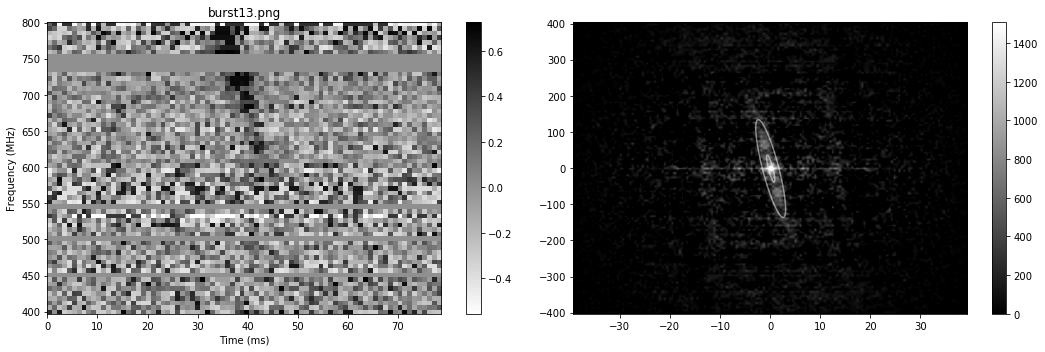

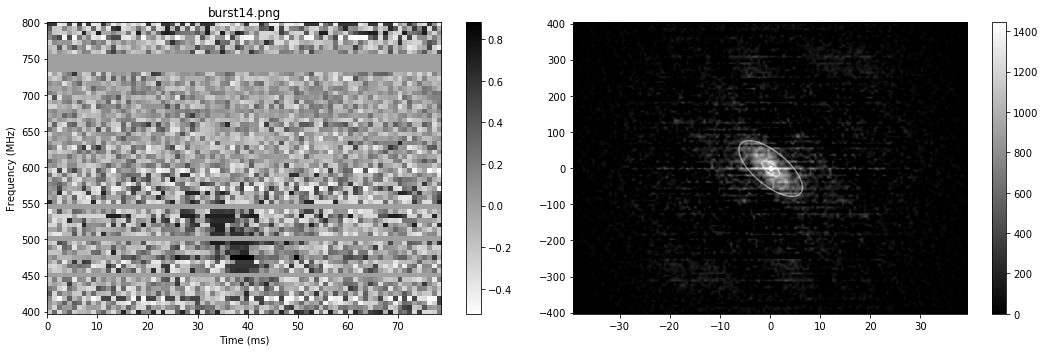

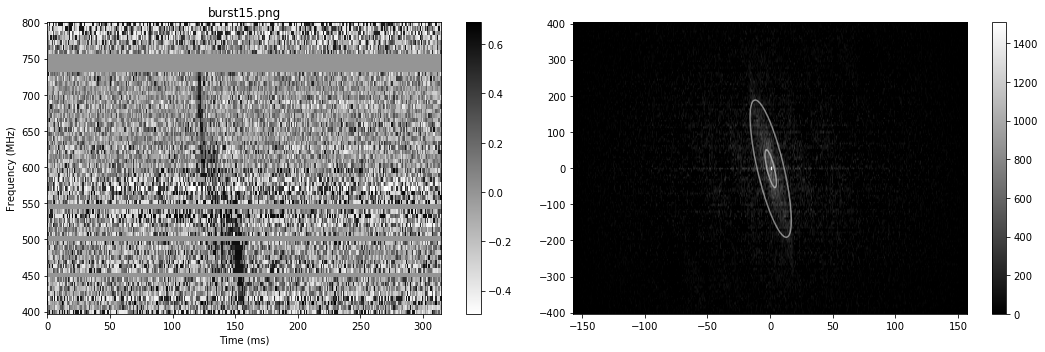

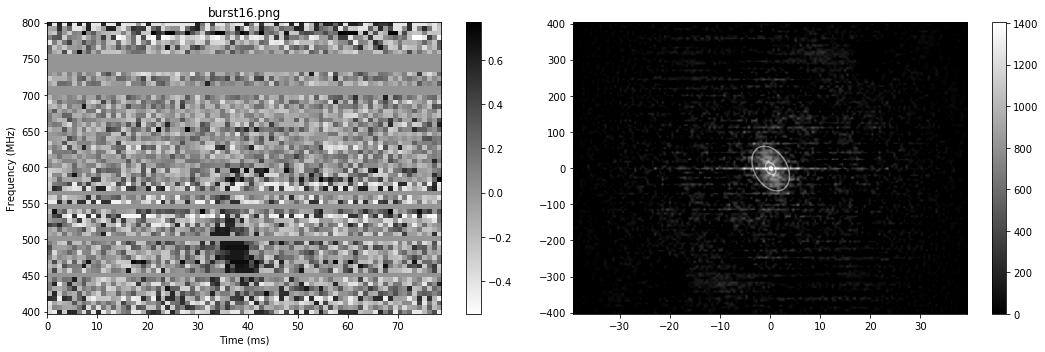

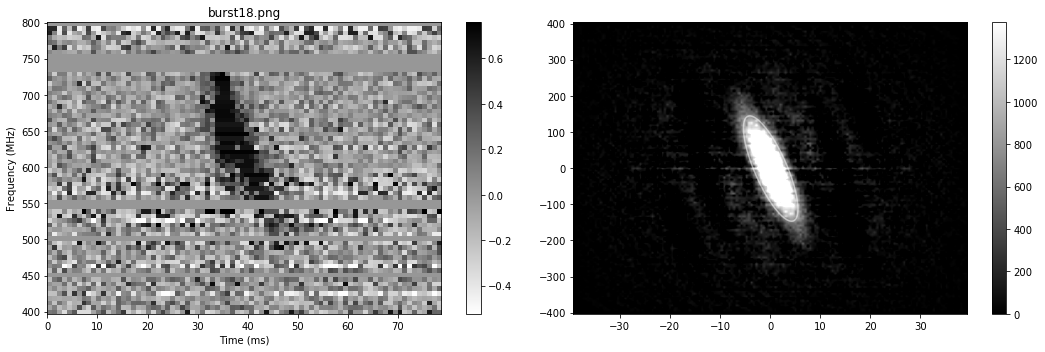

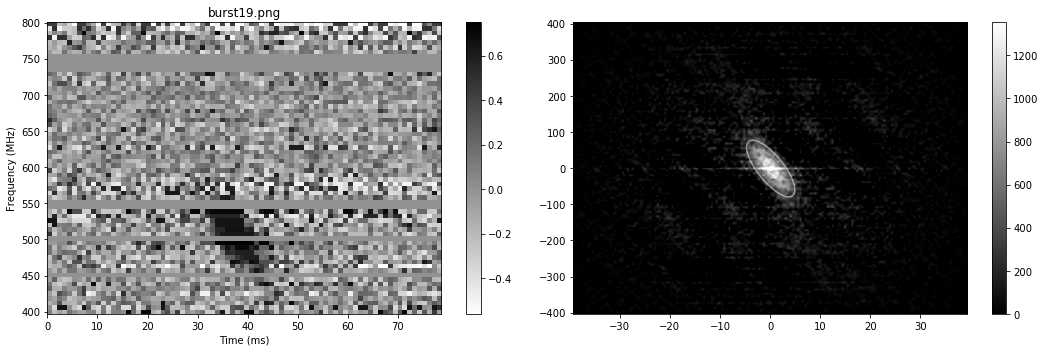

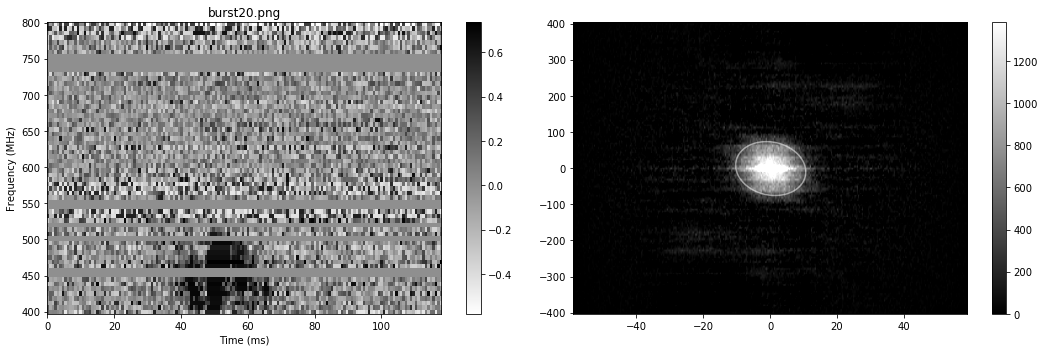

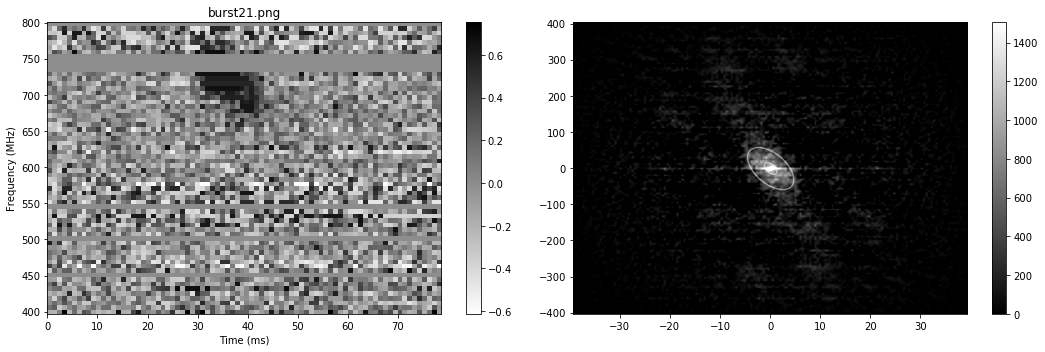

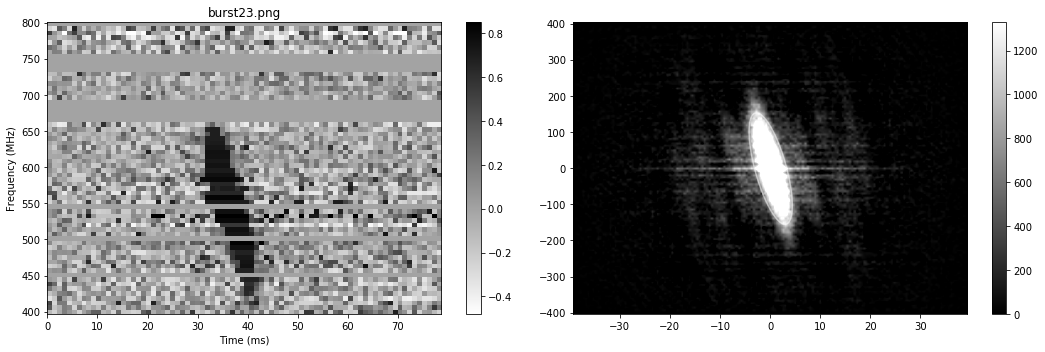

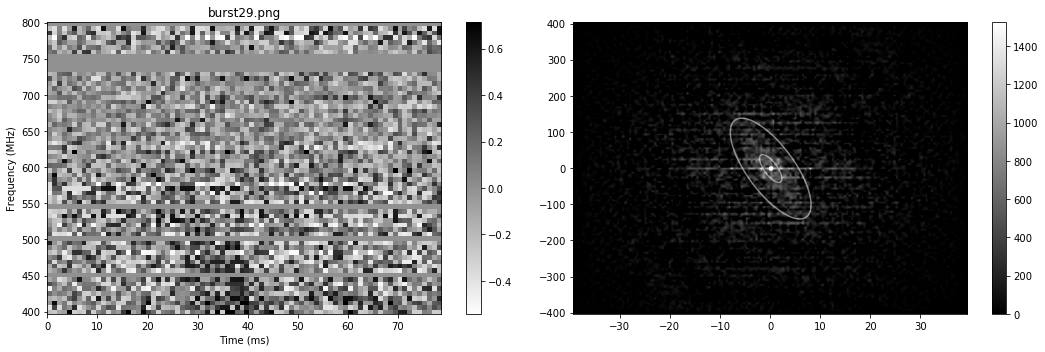

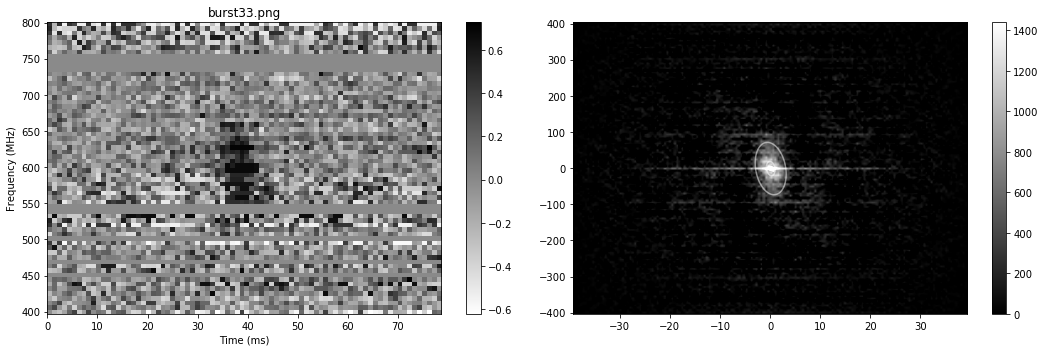

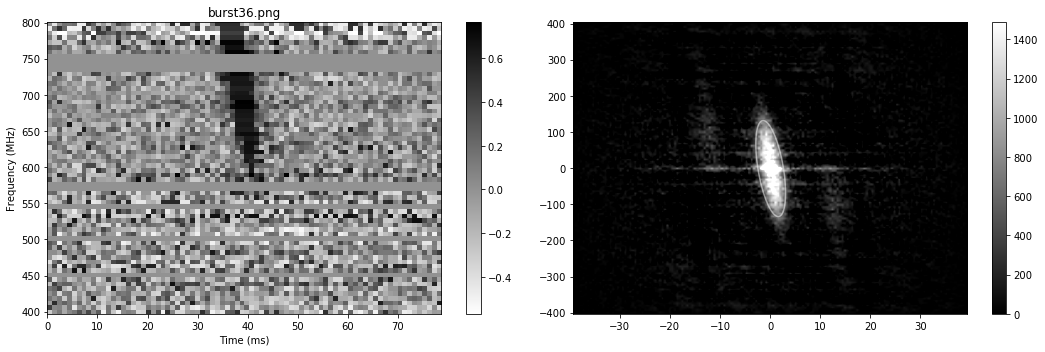

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import os
from tqdm import tqdm
import matplotlib.image as mpimg
import corrfns, fitburst

plt.rcParams.update({'figure.max_open_warning': 0})
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]) * rgb[...,3] # last factor is alpha mask

burstfolder = 'data/CHIME_180916_imgs/bursts'
wellbehaved = ['13', '14', '15', '16', '18', '19', '20', '21', '23', '29', '33', '36']

pixelscales = pd.read_csv('data/CHIME_180916_imgs/pixelscales.csv', index_col=0)
parameterfile = 'data/CHIME_180916_imgs/chime_180916_fit_params.csv'
errorfile     = 'data/CHIME_180916_imgs/chime_180916_param_errors.csv'

if os.path.exists(parameterfile):
    popts = pd.read_csv(parameterfile, index_col=0)
    perrs = pd.read_csv(errorfile, index_col=0)
else:
    popts, perrs = [], []

drifts       = []
drift_errors = []
red_chisqs   = []
angles       = [] # standardize theta to be in [0, pi] 

cmap = plt.get_cmap('gray')
cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!
for filename in tqdm(os.listdir(burstfolder)):
    if filename not in ['burst{}.png'.format(x) for x in wellbehaved]:
        continue
    #print('processing', filename)
    
    imfrb = mpimg.imread('{}/{}'.format(burstfolder, filename))
    grayfrb = (1 - rgb2gray(imfrb)) * imfrb[...,3] # 1 is bright, 0 is dim

    burstwindow = grayfrb - grayfrb[:, 0:100].mean(axis=1)[:,None]

    corr = corrfns.auto_corr2D_viafft(burstwindow)
    #### Autocorr noise
    autocorr_sigma = np.std( corr[:, 0:100] )
    # print('autocorr_sigma', autocorr_sigma)
    # auto_sigmas.append(autocorr_sigma)

    #### Fit Gaussian to autocorrelation. Load from parameter file if already found.
    if os.path.exists(parameterfile):
        # print('loading fit...')
        popt, perr = popts.loc[filename.split('.')[0]][:6], perrs.loc[filename.split('.')[0]][:6]
    else:        
        print("finding fit...")
        popt, pcov = fitburst.fitgaussiannlsq(corr, sigma=autocorr_sigma)
        perr = np.sqrt(np.diag(pcov))
        print('solution nlsq:', popt)
        print('parameter 1sigma:', perr)
        # print('pcov diag:', np.diag(pcov))
        # with np.printoptions(precision=3, suppress=True):
            # print('pcov:')
            # print(pcov)
        popts.append(popt)
        perrs.append(perr)

    x, y = np.meshgrid(range(0, corr.shape[1]), range(0, corr.shape[0]))
    # popt[5] = np.pi/2
    fitmap = fitburst.twoD_Gaussian((y, x), *popt).reshape(corr.shape[0], corr.shape[1])
    
    # calculate reduced chisquared
    residuals = corr - fitmap
    chisq = np.sum((residuals / autocorr_sigma) ** 2)
    red_chisq = chisq / (corr.shape[0]*corr.shape[1] - len(popt)) # this is chisq/(M-N)
    red_chisqs.append(red_chisq)
    # print('reduced chisq:', red_chisq)
    
    # Calculate drifit
    time_res = 0.98304 # ms
    freq_res = 6.25 # MHz
    lowest_freq = 400.20751953125 # MHZ
    pixelx_scale = pixelscales.loc[ int(filename.split('burst')[-1].split('.')[0]) ][0] # varies per burst, but usually 480 pixels / 80 points
    pixely_scale = pixelscales.loc[ int(filename.split('burst')[-1].split('.')[0]) ][1] # == 477 pixels / 64 data points

    theta = popt[5] if abs(popt[3]) < abs(popt[4]) else popt[5] - np.pi/2
    angles.append(theta) if theta > 0 else angles.append(theta + 2*np.pi)
    slope = np.tan(theta) * (pixelx_scale / pixely_scale)
    conversion = freq_res / (time_res)
    drift = conversion * slope # MHz/ms
    theta_err = perr[-1] # do i need to correct this for pixel scale?
    drift_error = conversion * (theta_err * (1/np.cos(theta))**2) * (pixelx_scale / pixely_scale)
    
    drifts.append(drift)
    drift_errors.append(drift_error)
    
    #### Plot
    extents = (0, 
               time_res*burstwindow.shape[1] / pixelx_scale, 
               lowest_freq - freq_res/2., 
               lowest_freq + freq_res*burstwindow.shape[0]/pixely_scale)
    
    corrextents = (-extents[1]/2, extents[1]/2, -(extents[3]-extents[2]), (extents[3]-extents[2]))
    
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.title(filename)
    plt.imshow(burstwindow, aspect='auto', cmap='gray_r', extent=extents) # white is 0, black is 1
    
    plt.xlabel("Time (ms)")
    plt.ylabel("Frequency (MHz)")
    plt.colorbar()

    plt.subplot(122)
    plt.imshow(corr, aspect='auto', cmap=cmap, extent=corrextents)
#     plt.plot(np.array((400, 600))-popt[1]+popt[2], -slope*(np.array((400, 600)) - popt[1]) +popt[2])
    plt.clim(0, np.max(corr)/10)
    plt.colorbar()
    plt.contour(fitmap, [popt[0]/4, popt[0]*0.9], colors='w', alpha=0.5, extent=corrextents, origin='upper')

plt.tight_layout()
plt.savefig(filename.split('.')[0] + 'corr')
    
if not os.path.exists(parameterfile):
    opts = pd.DataFrame(popts, index=['burst'+x for x in wellbehaved], columns=['amplitude', 'xo', 'yo', 'sigmaxp', 'sigmayp', 'theta'])
    errs = pd.DataFrame(perrs, index=['burst'+x for x in wellbehaved], columns=['amp_error', 'xo_error', 'yo_error', 'sigmaxp_error', 'sigmayp_error', 'angle_error'])
    opts.to_csv(parameterfile)
    errs.to_csv(errorfile)


popts['drift (mhz/ms)']       = drifts
popts['angle']                = angles
perrs['drift error (mhz/ms)'] = drift_errors
perrs['red_chisq']            = red_chisqs


# popts.to_csv(parameterfile)
# perrs.to_csv(errorfile)
popts

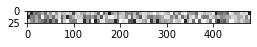

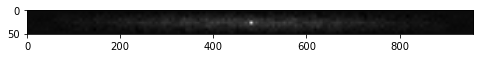

In [2]:
burstwindow = grayfrb[451:] - grayfrb[451:, 0:50].mean(axis=1)[:,None]
plt.figure(figsize=(4, 8))
plt.imshow(burstwindow, aspect='equal', cmap='gray_r') # white is 0, black is 1
# plt.axhline(y=85)
# plt.axhline(y=95)
# grayfrb[85:95]
corr = corrfns.auto_corr2D_viafft(burstwindow)
plt.figure(figsize=(8, 8))
plt.imshow(corr, aspect='equal', cmap='gray')